## Supplement Sales Prediction Solution

### 1. Importing necessary libraries

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [10]:
train_df = pd.read_csv('TRAIN.csv')

# to convert date in string format to date format.
train_order_date = train_df['Date']
train_df['Date'] = pd.to_datetime(train_df['Date'])

# extracting multiple features from date feature..(I have tried using year, month, week, day, but they didn't helped me much)
train_df['order_dayofweek'] = train_df['Date'].dt.dayofweek

print(train_df.shape)

(188340, 11)


### 2. Observing and understanding train and test data

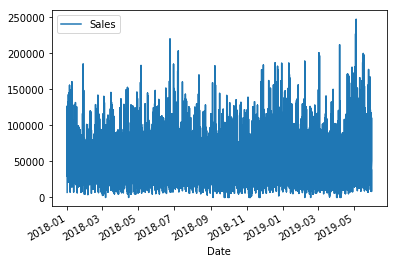

In [11]:
# plotting Date vs Sales to understand its importance

train_df.plot(x='Date', y='Sales')

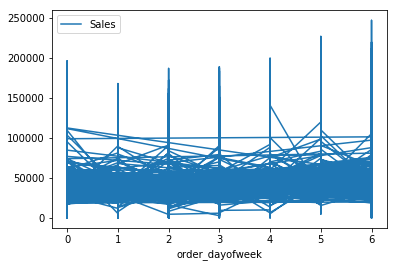

In [12]:
train_df.plot(x='order_dayofweek', y='Sales')

* 5 and 6 values of order_of_week seems important.

In [13]:
# applying same operations on test data like train data
test_df = pd.read_csv('TEST_FINAL.csv')

test_order_date = test_df['Date']
test_df['Date'] = pd.to_datetime(test_df['Date'])

test_df['order_dayofweek'] = test_df['Date'].dt.dayofweek

# removing Date feature from both train and test, it is used, and useful any more.
train_df = train_df.drop(['Date'], axis=1)
test_df = test_df.drop(['Date'], axis=1)

print(test_df.shape)
test_df.head()

(22265, 8)


,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,order_dayofweek
0,T1188341,171,S4,L2,R3,0,No,5
1,T1188342,172,S1,L1,R1,0,No,5
2,T1188343,173,S4,L2,R1,0,No,5
3,T1188344,174,S1,L1,R4,0,No,5
4,T1188345,170,S1,L1,R2,0,No,5


In [14]:
train_df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,#Order,Sales,order_dayofweek
0,T1000001,1,S1,L3,R1,1,Yes,9,7011.84,0
1,T1000002,253,S4,L2,R1,1,Yes,60,51789.12,0
2,T1000003,252,S3,L2,R1,1,Yes,42,36868.20,0
3,T1000004,251,S2,L3,R1,1,Yes,23,19715.16,0
4,T1000005,250,S2,L3,R4,1,Yes,62,45614.52,0


### 3 New feature using Date

In [15]:
# as per observation in graph(order_dayofweek vs Sales)..
# instead od 7 different values, we are keeping only two values, is_weekend.

train_df['is_week_end'] = [1 if i >= 5 else 0 for i in train_df['order_dayofweek'].values]

test_df['is_week_end'] = [1 if i >= 5 else 0 for i in test_df['order_dayofweek'].values]

# then we drop order_dayofweek, which is no more useful, we use is_weekend feature.
train_df = train_df.drop(['order_dayofweek'], axis=1)
test_df = test_df.drop(['order_dayofweek'], axis=1)

test_df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,is_week_end
0,T1188341,171,S4,L2,R3,0,No,1
1,T1188342,172,S1,L1,R1,0,No,1
2,T1188343,173,S4,L2,R1,0,No,1
3,T1188344,174,S1,L1,R4,0,No,1
4,T1188345,170,S1,L1,R2,0,No,1


### 4 splitting train data into train & cross_validation, to understand the correctness of the model.

In [16]:
# last 2 months is test and the rest is train.
X_train = train_df.iloc[:166074,:]

mean_sales = np.mean(train_df['Sales'])
# replacing 0 values with mean of sales value.
X_train['Sales'] = [mean_sales if X_train['Sales'].values[i] == 0 else X_train['Sales'].values[i] for i in range(len(X_train['Sales']))]

# we remove few columns in each dataset that are not useful.
Y_train = X_train['Sales']
X_train = X_train.drop(['ID', '#Order', 'Sales'], axis=1)

# last 2 months data as cross_validation data..
X_test = train_df.iloc[166075:,:]
Y_test = X_test['Sales']
X_test_ids = X_test['ID']
X_test = X_test.drop(['ID', '#Order', 'Sales'], axis=1)

temp_train = train_df
y_train_df = train_df['Sales']
train_df = train_df.drop(['ID', '#Order', 'Sales'], axis=1)

test_ids = test_df['ID']
test_df = test_df.drop(['ID'], axis=1)

print("Shape of new dataframes : {} , {}, {}, {}".format(X_train.shape, X_test.shape, train_df.shape, test_df.shape))
X_train.head()

Shape of new dataframes : (166074, 7) , (22265, 7), (188340, 7), (22265, 7)


,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,is_week_end
0,1,S1,L3,R1,1,Yes,0
1,253,S4,L2,R1,1,Yes,0
2,252,S3,L2,R1,1,Yes,0
3,251,S2,L3,R1,1,Yes,0
4,250,S2,L3,R4,1,Yes,0


### 5 Label Encoding Categorical features

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
var_mod = X_train.select_dtypes(include='object').columns
#var_mod = ['Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Discount', 'order_year', 'order_month', 'order_week', 'order_day', 'order_dayofweek']
for i in var_mod:
    X_train[i] = le.fit_transform(X_train[i])
for i in var_mod:
    X_test[i] = le.fit_transform(X_test[i])
for i in var_mod:
    train_df[i] = le.fit_transform(train_df[i])
for i in var_mod:
    test_df[i] = le.fit_transform(test_df[i])

### 6 Building ML models

In [18]:
#import sklearn.metrics
# sorted(sklearn.metrics.SCORERS.keys())

# from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
# LR = LinearRegression(normalize=True)
# LR = RandomForestRegressor()
# LR = XGBRegressor()

# --------------------------- Hyper parameter Tuning -----------------

#LR = XGBRegressor()
# from sklearn.metrics import mean_squared_log_error

# building custom scorer
# def msle(xt, yt):
#     mean_squared_log_error(xt, yt)*1000
# from sklearn.metrics import make_scorer
# my_scorer = make_scorer(msle, greater_is_better=True)

# from sklearn.model_selection import GridSearchCV
# parameters = {'max_depth': [i for i in range(2, 7)], 'n_estimators': [50, 100, 150]}
# clf = GridSearchCV(LR, parameters, cv=3, scoring=my_scorer)
# clf.fit(X_train,Y_train)

# best_depth = clf.best_estimator_.max_depth
# best_n_estimators = clf.best_estimator_.n_estimators

# best_depth, best_n_estimators

In [19]:
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.linear_model import LinearRegression
#LR = RandomForestRegressor(max_depth = best_depth, n_estimators = best_n_estimators, random_state=0)
#LR = DecisionTreeRegressor(max_depth=5, random_state=0)

# comapred to all other algorithms XGBRegressor worked well..
from xgboost import XGBRegressor
LR = XGBRegressor(max_depth = 7, eta=0.28)

LR.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.28, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.280000001, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
y_pred = LR.predict(X_test)
# observing the results..
print(y_pred[22255:], Y_test.values[22255:], np.mean(Y_train.values), np.mean(Y_test.values), np.mean(y_pred))

from sklearn.metrics import mean_squared_log_error
# based on this score I decide for test_submission in hackthon.. it helped.
mean_squared_log_error(Y_test, y_pred)*1000 # 91.20856913449634(7,0.25) # moved_to_2_ranks_up : 91.16259523735164

[45795.7   19465.688 52089.266 44327.977 21783.53  27865.09  51283.883
 24007.201 38769.125 23955.959] [48026.88 27760.08 86994.18 50018.34 24105.6  37272.   54572.64 31624.56
 49162.41 37977.  ] 42433.425078939035 45430.85696833596 41567.195


91.16259523735164

In [21]:
# preparing the total train data to build model on it

train_df['Sales'] = temp_train['Sales']
train_df['Sales'] = [mean_sales if train_df['Sales'].values[i] == 0 else train_df['Sales'].values[i] for i in range(len(train_df['Sales']))]
train_df = train_df.drop(['Sales'], axis=1)

train_df.head()

,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,is_week_end
0,1,0,2,0,1,1,0
1,253,3,1,0,1,1,0
2,252,2,1,0,1,1,0
3,251,1,2,0,1,1,0
4,250,1,2,3,1,1,0


In [22]:
LR = XGBRegressor(max_depth = 7, eta=0.28)
LR.fit(train_df,y_train_df)
y_pred = LR.predict(test_df)

In [23]:
# storeing the results in dataframe
submit_df = pd.DataFrame()

submit_df['ID'] = test_ids
submit_df['Sales'] = y_pred

submit_df.head()

,ID,Sales
0,T1188341,54762.269531
1,T1188342,39595.925781
2,T1188343,77684.804688
3,T1188344,37862.851562
4,T1188345,40425.003906


In [24]:
# comparing the current solution with old best solution.
# if the difference is significant I will think of submitting the results.
old_solution = pd.read_csv('test_prediction_xGBr_zero_effect.csv')
y_pred_old = old_solution['Sales']
print(old_solution.head())

mean_squared_log_error(y_pred_old, y_pred)*1000, np.mean(y_pred_old), np.mean(y_train_df), np.mean(y_pred) # 4.4239

         ID      Sales
0  T1188341  55304.117
1  T1188342  39618.770
2  T1188343  78060.840
3  T1188344  37792.830
4  T1188345  40129.460


(0.1098704393763147, 43427.32800999307, 42787.735462247714, 43427.375)

In [ ]:
# submit_df is the required solution.